In [15]:
%matplotlib inline

Hello

In this notebook i’ll talk a little about an analysis of the data released by the american government about colleges. This data can be found at: https://collegescorecard.ed.gov/data/

For this analysis, i used Python with Pandas and Numpy, matplotlib and Seaborn for the plots.

All the code can be found on Github:

## Preparation

Well, first we will import the required libraries:

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Then we’ll read the CSV. We’ll use the data from 2005, because this is the latest year where the earnings informations are available.

We will also turn off chained assignment warnings from Pandas because it would give us some false positive warnings.

In [17]:
# Import the Dataset from 2005 to a Pandas DataFrame
us_college_data = pd.read_csv("college-scorecard-raw-data-030216/merged_2005_PP.csv")

# Turn off chained assignment warnings on Pandas
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\Luciana\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Cleaning

We will start the cleaning removing the duplicated data based on the opeid6 column. Then we’ll change values that are equal to “PrivacySuppressed” and “NULL” for columns GRAD_DEBT_MDN (the median debt of the students) and md_earn_wne_p6 (median earnings 6 years after entry):

In [18]:
# Remove duplicates on the dataframe based on the opeid6 column, since
# earnings and debt informations is the same
us_college_data = us_college_data.drop_duplicates(['opeid6'])

# Change NULL and PrivacySuppresed values on column to NaN, then convert
# everything to numeric
us_college_data.GRAD_DEBT_MDN[us_college_data.GRAD_DEBT_MDN == "PrivacySuppressed"] = np.nan
us_college_data.GRAD_DEBT_MDN[us_college_data.GRAD_DEBT_MDN == "NULL"] = np.nan
us_college_data.GRAD_DEBT_MDN = pd.to_numeric(us_college_data.GRAD_DEBT_MDN)

# Do the same cleaning for the earnings in 6 years column
us_college_data.md_earn_wne_p6[us_college_data.md_earn_wne_p6 == "PrivacySuppressed"] = np.nan
us_college_data.md_earn_wne_p6[us_college_data.md_earn_wne_p6 == "NULL"] = np.nan
us_college_data.md_earn_wne_p6 = pd.to_numeric(us_college_data.md_earn_wne_p6)

## Features

We are also going to create some new features. Here they are:

### Earnings to Debt Ratio

This feature will calculate the ratio between the median earnings 6 months from entry and the average debt for each college. Below is the code:

In [19]:
# Create a column on the DF for Earnings to Debt ratio (earnings / debt)
us_college_data['earnings_debt_ratio'] = pd.Series(us_college_data.md_earn_wne_p6 / us_college_data.GRAD_DEBT_MDN, 
                                                   index=us_college_data.index)

### Months to pay the average debt

On this feature we make some assumptions. We assume that 10% of the median earnings are used to pay the debt and calculate, based on that, the number of months necessary to pay the debt in each college. There’s the code:

In [20]:
us_college_data['months_to_pay'] = pd.Series(us_college_data.GRAD_DEBT_MDN / (us_college_data.md_earn_wne_p6 / 10 / 12), 
                                             index=us_college_data.index)

We are also going to set some constant variables, that are the US average per capita income for 2011 (6 years from 2011, according to the dataset variable) and the average student loan debt for 2005 (source: http://www.forbes.com/sites/halahtouryalai/2013/01/29/more-evidence-on-the-student-debt-crisis-average-grads-loan-jumps-to-27000/)

In [21]:
# Set constant variables about the US average per capita income
# and average student loan debt (debt for 2005, income for 2011 (6 years after entry))
us_per_capita_income = 49781.4
us_avg_stdnt_loan_debt = 17233

## Filtering and Sorting by Earnings to Debt

Now we will do some filtering to show some stuff related to the Earnings to Debt ratio feature that we created. We are going to leave only colleges that have a median earning above the US average per capita income and the average debt lower than the average student loan debt, and then we will sort and get the top 10 based on the earnings to debt ratio, with the code below:

In [22]:
# Filter the colleges where the earnings average is above 
# and the average debt is lesser than the US average
selected_colleges = us_college_data[(us_college_data.md_earn_wne_p6 > us_per_capita_income) & 
                                    (us_college_data.GRAD_DEBT_MDN < us_avg_stdnt_loan_debt)]

# Sort the data frame by the ratio column and select the top 10
top_10_selected_by_ratio = selected_colleges.sort_values(by='earnings_debt_ratio', ascending=False)
top_10_selected_by_ratio = top_10_selected_by_ratio.iloc[:10]

# Here we'll trim the college names so that they don't mess up the plot
top_10_selected_by_ratio['Institution'] = pd.Series(top_10_selected_by_ratio.INSTNM.str[0:29], 
                                                    index=top_10_selected_by_ratio.index)

## Plotting the top 10 colleges by earnings to debt ratio

Now we will plot the top 10 colleges sorted by earnings to debt ratio. Matplotlib will mess with the x labels a little, specially if we have larger names for it, but it is perfectly possible to understand the order of the plot:

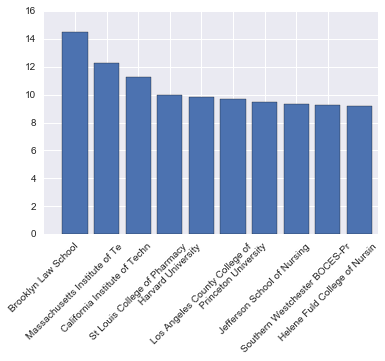

In [23]:
# Plot bar chart with the top 10 colleges by Earnings to Debt Ratio
y_axis = top_10_selected_by_ratio.earnings_debt_ratio
x_pos = np.arange(len(top_10_selected_by_ratio.Institution))
x_labels = top_10_selected_by_ratio.Institution

plt.bar(x_pos, y_axis)
plt.xticks(x_pos-0.6, tuple(x_labels), rotation=45)
plt.show()

And on the table below, the details about the plot that you just saw:

In [24]:
# Print the according table
print(top_10_selected_by_ratio[["Institution","md_earn_wne_p6","GRAD_DEBT_MDN",
                                "earnings_debt_ratio", "months_to_pay"]])

                        Institution  md_earn_wne_p6  GRAD_DEBT_MDN  \
2649            Brooklyn Law School           86900         6000.0   
1910  Massachusetts Institute of Te           75300         6125.0   
245   California Institute of Techn           62100         5500.0   
2348   St Louis College of Pharmacy          115900        11625.0   
1886             Harvard University           60200         6125.0   
424   Los Angeles County College of           83700         8647.5   
2555           Princeton University           52300         5500.0   
173     Jefferson School of Nursing           54600         5859.0   
2786  Southern Westchester BOCES-Pr           61300         6625.0   
2731  Helene Fuld College of Nursin           85200         9250.0   

      earnings_debt_ratio  months_to_pay  
2649            14.483333       8.285386  
1910            12.293878       9.760956  
245             11.290909      10.628019  
2348             9.969892      12.036238  
1886          

## Now, the top 10 by earnings

We will do the same plotting as above, but now we will consider the colleges that will leave you with the highest average earnings. First, we’ll select the top 10 colleges by earnings that meet the requirements:

In [25]:
# Get the top 10 colleges by earnings
top_10_selected_by_earnings = selected_colleges.sort_values(by='md_earn_wne_p6', ascending=False)
top_10_selected_by_earnings = top_10_selected_by_earnings.iloc[:10]
top_10_selected_by_earnings['Institution'] = pd.Series(top_10_selected_by_earnings.INSTNM.str[0:29], 
                                                       index=top_10_selected_by_earnings.index)

And then plot the data:

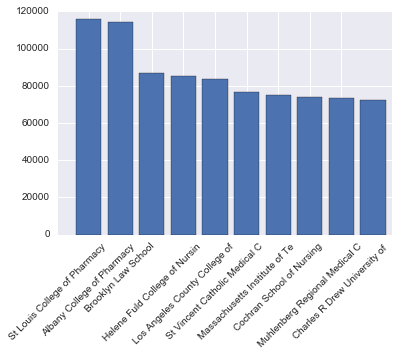

In [26]:
# Plot bar chart with top 10 colleges by earnings
y_axis = top_10_selected_by_earnings.md_earn_wne_p6
x_pos = np.arange(len(top_10_selected_by_earnings.Institution))
x_labels = top_10_selected_by_earnings.Institution

plt.bar(x_pos, y_axis)
plt.xticks(x_pos-0.6, tuple(x_labels), rotation=45)
plt.show()

And the associated table:

In [27]:
# Print according table
print(top_10_selected_by_earnings[["Institution","md_earn_wne_p6","GRAD_DEBT_MDN",
                                   "earnings_debt_ratio", "months_to_pay"]])

                        Institution  md_earn_wne_p6  GRAD_DEBT_MDN  \
2348   St Louis College of Pharmacy          115900        11625.0   
2622     Albany College of Pharmacy          114500        17125.0   
2649            Brooklyn Law School           86900         6000.0   
2731  Helene Fuld College of Nursin           85200         9250.0   
424   Los Angeles County College of           83700         8647.5   
2661  St Vincent Catholic Medical C           76800        10750.0   
1910  Massachusetts Institute of Te           75300         6125.0   
2671      Cochran School of Nursing           73800        14125.0   
2541  Muhlenberg Regional Medical C           73400        14125.0   
299   Charles R Drew University of            72600        14125.0   

      earnings_debt_ratio  months_to_pay  
2348             9.969892      12.036238  
2622             6.686131      17.947598  
2649            14.483333       8.285386  
2731             9.210811      13.028169  
424           

## Correlation between Earnings and Tuition

To finish, we’ll check if bigger tuitions lead to bigger earnings. Let’s calculate the correlation between the two variables:

In [28]:
# Calculate the correlation between the Tuition Fee and Earnings
print(us_college_data['TUITIONFEE_IN'].corr(us_college_data['md_earn_wne_p6']))

0.471630310675


And then, check it on a scatterplot:

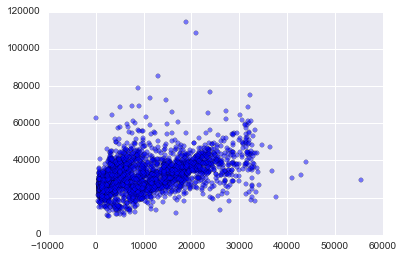

In [29]:
# Scatter plot comparing Tuition with earnings
scatter_plot = plt.scatter(us_college_data['TUITIONFEE_IN'], us_college_data['md_earn_wne_p6'],
                           alpha=0.5)